# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 4 — Gaussians

---

Submission by:
* Batuhan, Oezcoemlekci, Matrikelnummer: 6300476
* Aakarsh, Nair, Matrikelnummer: 6546577

In [100]:
import jax.numpy as jnp
import logging

from jax import random
key = random.PRNGKey(0)
from exponential_families import *
from tueplots import bundles
from matplotlib import pyplot as plt
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 200})

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

## Exercise 4.2 (Coding Exercise)

> This week's Exercise is directly taken from Exercise 24.3. of [David JC MacKay](https://en.wikipedia.org/wiki/David_J._C._MacKay)'s [*Information Theory, Inference, and Learning Algorithms*](http://www.inference.org.uk/mackay/itila/). (But don't waste your time trying to find an answer there :)

The terribly important quantity $\mu$ has been experimentally measured by seven scientists (A, B, C, D, E, F, G) with wildly differing experimental skills. They have reported the following measurements:

In [101]:
# We assume the same latent quantity $\mu$ for all observations.
X = jnp.array([-27.020,3.570,8.191,9.898,9.603,9.945,10.056])

Text(0.5, 0, 'measured value of $x$')

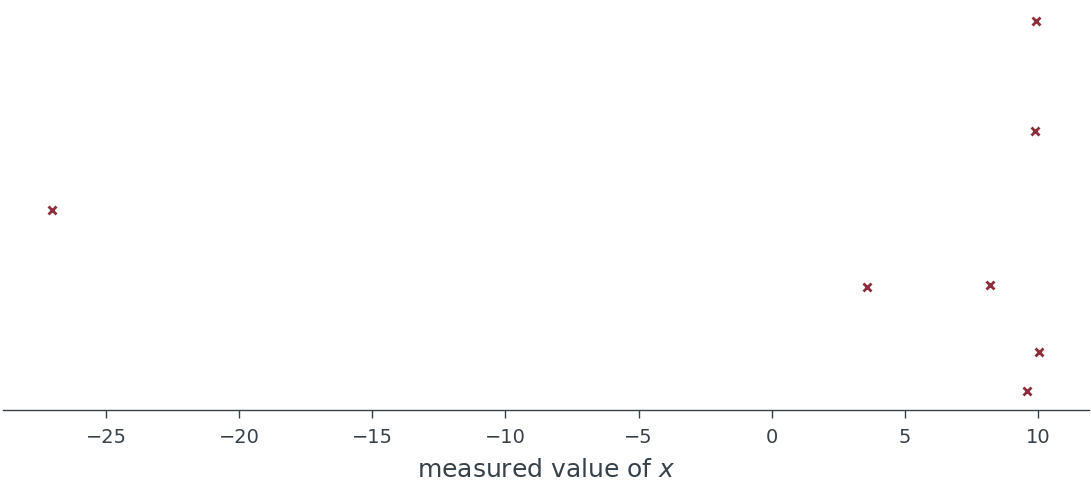

In [102]:
fig,ax = plt.subplots(1,1)
ax.plot(X,random.uniform(key, shape=(7,)),'x',ms=3)

ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('measured value of $x$')

We assume that they have all, independently of each other, made an unbiased Gaussian measurement of $\mu$: 
$$p(\boldsymbol{x}\mid \mu,\boldsymbol{\sigma}) = \prod_{i=1} ^7 \mathcal{N}(x_i;\mu,\sigma_i ^2).$$ 
But we have to assume that their measurement errors $\sigma_i$ vary a lot (some are skilled experimentalists, others are unqualified). 

#### Task A: 
Implement the likelihood above as a single jax function (this is unfortunately a case where our neat `ExponentialFamily` base class is more awkward than useful). Try using a numerical optimizer to find *maximum likelihood estimators*, i.e. points $(\mu, \vec{\sigma})$ that maximize this function. Alternatively, you can try and identify such points directly by inspecting the likelihood by hand.
  
You probably agree that, intuitively, it looks pretty certain that A and B are both inept measurers, that D–G are better, and that the true value of $\mu$ is somewhere close to $10$. Are your findings consistent with this intuition?  

In [445]:
import jax
import jax.numpy as jnp
import jax.scipy.optimize as optimize

def log_likelihood(params, data):
    mean = params[0]
    log_probs = [0  for _ in range(data.shape[0])]
    for i in range(data.shape[0]):
        log_probs[i] = jax.scipy.stats.norm.logpdf(data[i], loc=mean, scale=jnp.exp((1e-3+params[i+1]) ))
    return jnp.sum(jnp.array(log_probs))

def negative_log_likelihood(params, data):
    return -log_likelihood(params, data)

# Does not have much data to deviate from the initialization, But the mean is 
# is close to 10 as was expected from the plot above.
#initial_params = jnp.zeros(8,) 
# #(mean, std): 10.037241 [33.581936    6.4427376   7.329081    1.669426    1.279549    0.5761264, 0.32330853]
initial_params = jnp.hstack([jnp.median(X), jnp.log((1e-3+ jnp.abs(X - jnp.median(X))))]) #jnp.sqrt((X - jnp.median(X))**2)])
print("Initial_params", initial_params[0], jnp.exp(1e-3+initial_params[1:]))
data = X  # Your measurements as an array-like object

result = optimize.minimize(negative_log_likelihood, initial_params, args=(data,), method='BFGS')
estimated_params = result.x

print("Estimated Parameters (mean, std):", estimated_params[0], jnp.exp(1e-3+estimated_params[1:]))
expected_mean = 10;
expected_deviation = np.sqrt((X - expected_mean)**2)
print("Expected Parameters (mean, std):", expected_mean, expected_deviation)
print("Residuals:(mean, std):", estimated_params[0]-expected_mean, np.abs(jnp.exp(1e-3+estimated_params[1:])-expected_deviation))

Initial_params 9.603 [3.6660637e+01 6.0400372e+00 1.4144135e+00 2.9629624e-01 1.0010003e-03
 3.4334320e-01 4.5445427e-01]
Estimated Parameters (mean, std): 9.603007 [3.6660637e+01 6.0400372e+00 1.4144135e+00 2.9629624e-01 1.0009994e-03
 3.4334320e-01 4.5445427e-01]
Expected Parameters (mean, std): 10 [37.02        6.4300003   1.809       0.10200024  0.3970003   0.05500031
  0.05599976]
Residuals:(mean, std): -0.39699268 [0.35936356 0.38996315 0.39458656 0.194296   0.3959993  0.2883429
 0.39845452]


We learn the standard deviation on the log scale and mean on linear scale. The minimizer is found to be extremely sensitive to initialization. We found both zero and median initialization allowed for good results.